


## Exploratory data analysis  & Predictive modeling of customer bookings

This Jupyter notebook includes exploratory data analysis of customer booking data for a airline company to better understand the statistical properties of the dataset.

After that a classification model is built and evaluated to predict customer booking possibilities for any future customers based on given features.


In [1]:
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB
from sklearn.naive_bayes import ComplementNB

from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import OneHotEncoder

from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.tree import DecisionTreeClassifier
# !pip install xgboost

import xgboost as xgb
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import RandomForestClassifier

from sklearn.metrics import f1_score

In [2]:
df = pd.read_csv("data/customer_booking.csv", encoding="ISO-8859-1")
df.head()

,num_passengers,sales_channel,trip_type,purchase_lead,length_of_stay,flight_hour,flight_day,route,booking_origin,wants_extra_baggage,wants_preferred_seat,wants_in_flight_meals,flight_duration,booking_complete
0,2,Internet,RoundTrip,262,19,7,Sat,AKLDEL,New Zealand,1,0,0,5.52,0
1,1,Internet,RoundTrip,112,20,3,Sat,AKLDEL,New Zealand,0,0,0,5.52,0
2,2,Internet,RoundTrip,243,22,17,Wed,AKLDEL,India,1,1,0,5.52,0
3,1,Internet,RoundTrip,96,31,4,Sat,AKLDEL,New Zealand,0,0,1,5.52,0
4,2,Internet,RoundTrip,68,22,15,Wed,AKLDEL,India,1,0,1,5.52,0


The `.head()` method allows us to view the first 5 rows in the dataset, this is useful for visual inspection of our columns

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 14 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   num_passengers         50000 non-null  int64  
 1   sales_channel          50000 non-null  object 
 2   trip_type              50000 non-null  object 
 3   purchase_lead          50000 non-null  int64  
 4   length_of_stay         50000 non-null  int64  
 5   flight_hour            50000 non-null  int64  
 6   flight_day             50000 non-null  object 
 7   route                  50000 non-null  object 
 8   booking_origin         50000 non-null  object 
 9   wants_extra_baggage    50000 non-null  int64  
 10  wants_preferred_seat   50000 non-null  int64  
 11  wants_in_flight_meals  50000 non-null  int64  
 12  flight_duration        50000 non-null  float64
 13  booking_complete       50000 non-null  int64  
dtypes: float64(1), int64(8), object(5)
memory usage: 5.3+ 

The `.info()` method gives us a data description, telling us the names of the columns, their data types and how many null values we have. Fortunately, we have no null values. It looks like some of these columns should be converted into different data types, e.g. flight_day.

To provide more context, below is a more detailed data description, explaining exactly what each column means:

- `num_passengers` = number of passengers travelling
- `sales_channel` = sales channel booking was made on
- `trip_type` = trip Type (Round Trip, One Way, Circle Trip)
- `purchase_lead` = number of days between travel date and booking date
- `length_of_stay` = number of days spent at destination
- `flight_hour` = hour of flight departure
- `flight_day` = day of week of flight departure
- `route` = origin -> destination flight route
- `booking_origin` = country from where booking was made
- `wants_extra_baggage` = if the customer wanted extra baggage in the booking
- `wants_preferred_seat` = if the customer wanted a preferred seat in the booking
- `wants_in_flight_meals` = if the customer wanted in-flight meals in the booking
- `flight_duration` = total duration of flight (in hours)
- `booking_complete` = flag indicating if the customer completed the booking

Before we compute any statistics on the data, lets do any necessary data conversion

In [4]:
df["flight_day"].unique()

array(['Sat', 'Wed', 'Thu', 'Mon', 'Sun', 'Tue', 'Fri'], dtype=object)

In [5]:
mapping = {
    "Mon": 1,
    "Tue": 2,
    "Wed": 3,
    "Thu": 4,
    "Fri": 5,
    "Sat": 6,
    "Sun": 7,
}

df["flight_day"] = df["flight_day"].map(mapping)

In [6]:
df["flight_day"].unique()

array([6, 3, 4, 1, 7, 2, 5], dtype=int64)

In [7]:
df.describe()

,num_passengers,purchase_lead,length_of_stay,flight_hour,flight_day,wants_extra_baggage,wants_preferred_seat,wants_in_flight_meals,flight_duration,booking_complete
count,50000.000000,50000.000000,50000.00000,50000.00000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000
mean,1.591240,84.940480,23.04456,9.06634,3.814420,0.668780,0.296960,0.427140,7.277561,0.149560
std,1.020165,90.451378,33.88767,5.41266,1.992792,0.470657,0.456923,0.494668,1.496863,0.356643
min,1.000000,0.000000,0.00000,0.00000,1.000000,0.000000,0.000000,0.000000,4.670000,0.000000
25%,1.000000,21.000000,5.00000,5.00000,2.000000,0.000000,0.000000,0.000000,5.620000,0.000000
50%,1.000000,51.000000,17.00000,9.00000,4.000000,1.000000,0.000000,0.000000,7.570000,0.000000
75%,2.000000,115.000000,28.00000,13.00000,5.000000,1.000000,1.000000,1.000000,8.830000,0.000000
max,9.000000,867.000000,778.00000,23.00000,7.000000,1.000000,1.000000,1.000000,9.500000,1.000000


The `.describe()` method gives us a summary of descriptive statistics over the entire dataset (only works for numeric columns). This gives us a quick overview of a few things such as the mean, min, max and overall distribution of each column.

From this point, you should continue exploring the dataset with some visualisations and other metrics that you think may be useful. Then, you should prepare your dataset for predictive modelling. Finally, you should train your machine learning model, evaluate it with performance metrics and output visualisations for the contributing variables. All of this analysis should be summarised in your single slide.

In [8]:
df.head()

,num_passengers,sales_channel,trip_type,purchase_lead,length_of_stay,flight_hour,flight_day,route,booking_origin,wants_extra_baggage,wants_preferred_seat,wants_in_flight_meals,flight_duration,booking_complete
0,2,Internet,RoundTrip,262,19,7,6,AKLDEL,New Zealand,1,0,0,5.52,0
1,1,Internet,RoundTrip,112,20,3,6,AKLDEL,New Zealand,0,0,0,5.52,0
2,2,Internet,RoundTrip,243,22,17,3,AKLDEL,India,1,1,0,5.52,0
3,1,Internet,RoundTrip,96,31,4,6,AKLDEL,New Zealand,0,0,1,5.52,0
4,2,Internet,RoundTrip,68,22,15,3,AKLDEL,India,1,0,1,5.52,0


In [9]:
df.dtypes

num_passengers             int64
sales_channel             object
trip_type                 object
purchase_lead              int64
length_of_stay             int64
flight_hour                int64
flight_day                 int64
route                     object
booking_origin            object
wants_extra_baggage        int64
wants_preferred_seat       int64
wants_in_flight_meals      int64
flight_duration          float64
booking_complete           int64
dtype: object

In [10]:
cats=['wants_extra_baggage','wants_preferred_seat','wants_in_flight_meals']
for col in cats:
    df[col]=df[col].astype('object')

In [11]:
df.dtypes

num_passengers             int64
sales_channel             object
trip_type                 object
purchase_lead              int64
length_of_stay             int64
flight_hour                int64
flight_day                 int64
route                     object
booking_origin            object
wants_extra_baggage       object
wants_preferred_seat      object
wants_in_flight_meals     object
flight_duration          float64
booking_complete           int64
dtype: object

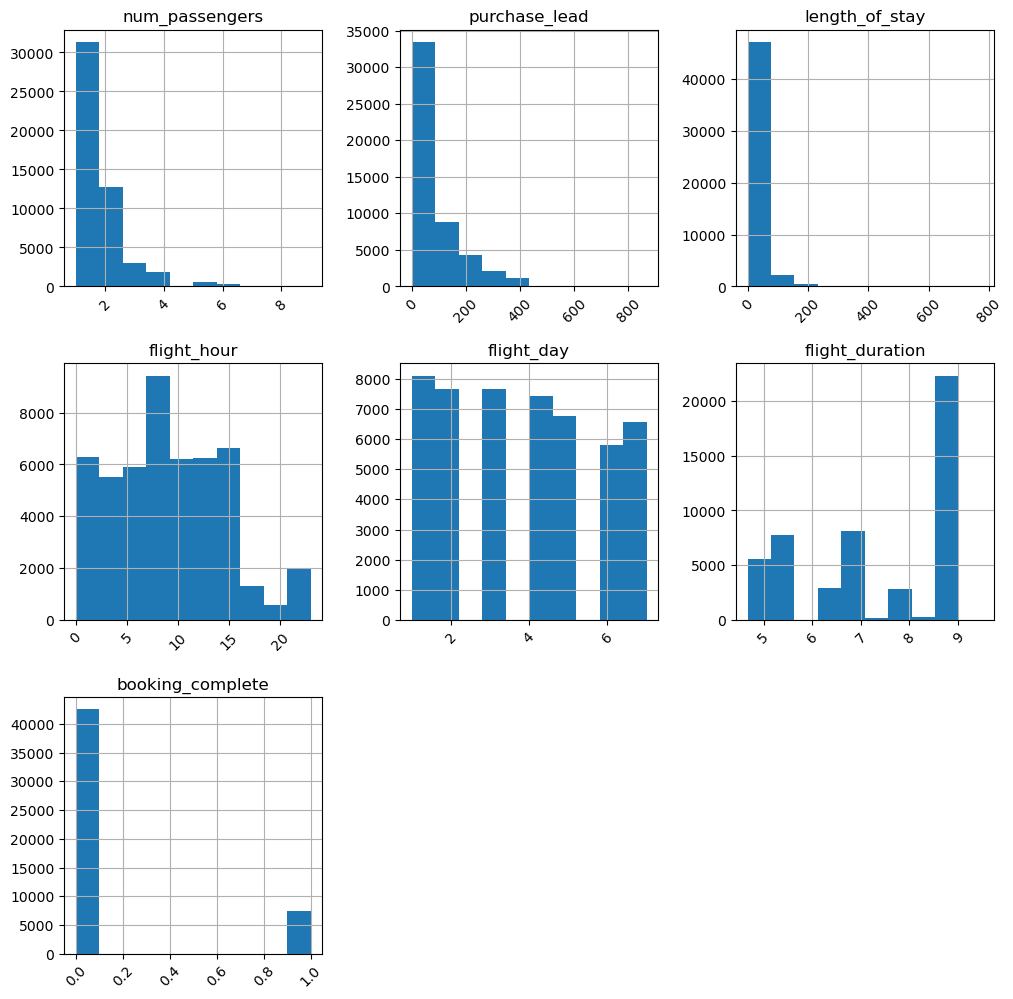

In [12]:
df.hist(figsize=(12,12), xrot=45)
plt.show()

In [13]:
df.describe()

,num_passengers,purchase_lead,length_of_stay,flight_hour,flight_day,flight_duration,booking_complete
count,50000.000000,50000.000000,50000.00000,50000.00000,50000.000000,50000.000000,50000.000000
mean,1.591240,84.940480,23.04456,9.06634,3.814420,7.277561,0.149560
std,1.020165,90.451378,33.88767,5.41266,1.992792,1.496863,0.356643
min,1.000000,0.000000,0.00000,0.00000,1.000000,4.670000,0.000000
25%,1.000000,21.000000,5.00000,5.00000,2.000000,5.620000,0.000000
50%,1.000000,51.000000,17.00000,9.00000,4.000000,7.570000,0.000000
75%,2.000000,115.000000,28.00000,13.00000,5.000000,8.830000,0.000000
max,9.000000,867.000000,778.00000,23.00000,7.000000,9.500000,1.000000


In [14]:
df['departure']=list(map(lambda x:x[0:3], df['route']) )
df['arrival']=list(map(lambda x:x[3:6], df['route']) )

In [15]:
data=df.copy()

In [16]:
data=df.drop(columns='route')

In [17]:
data.head()

,num_passengers,sales_channel,trip_type,purchase_lead,length_of_stay,flight_hour,flight_day,booking_origin,wants_extra_baggage,wants_preferred_seat,wants_in_flight_meals,flight_duration,booking_complete,departure,arrival
0,2,Internet,RoundTrip,262,19,7,6,New Zealand,1,0,0,5.52,0,AKL,DEL
1,1,Internet,RoundTrip,112,20,3,6,New Zealand,0,0,0,5.52,0,AKL,DEL
2,2,Internet,RoundTrip,243,22,17,3,India,1,1,0,5.52,0,AKL,DEL
3,1,Internet,RoundTrip,96,31,4,6,New Zealand,0,0,1,5.52,0,AKL,DEL
4,2,Internet,RoundTrip,68,22,15,3,India,1,0,1,5.52,0,AKL,DEL


In [18]:
data.describe(include='object')

,sales_channel,trip_type,booking_origin,wants_extra_baggage,wants_preferred_seat,wants_in_flight_meals,departure,arrival
count,50000,50000,50000,50000,50000,50000,50000,50000
unique,2,3,104,2,2,2,85,64
top,Internet,RoundTrip,Australia,1,0,0,DMK,SYD
freq,44382,49497,17872,33439,35152,28643,3747,6616


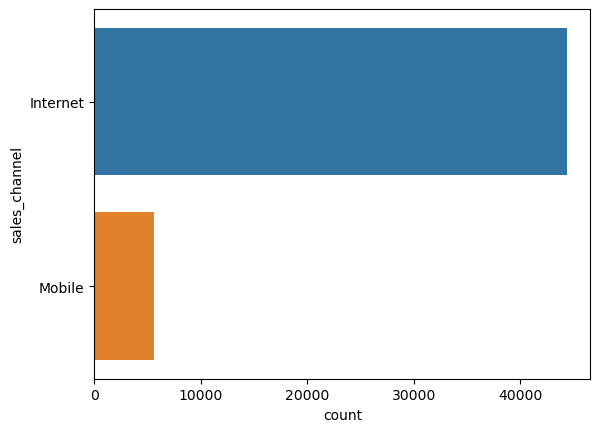

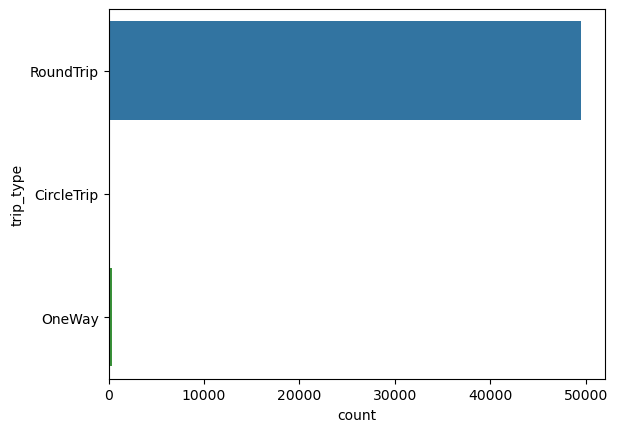

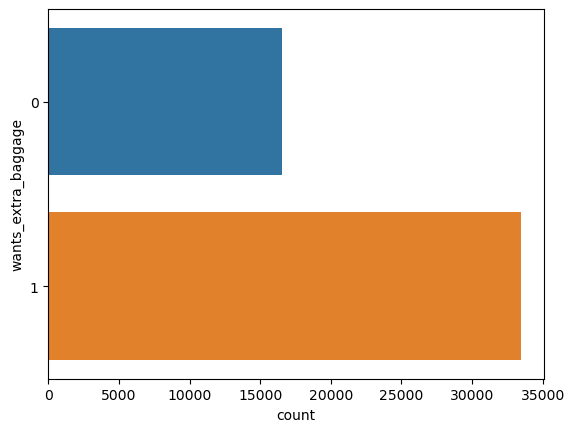

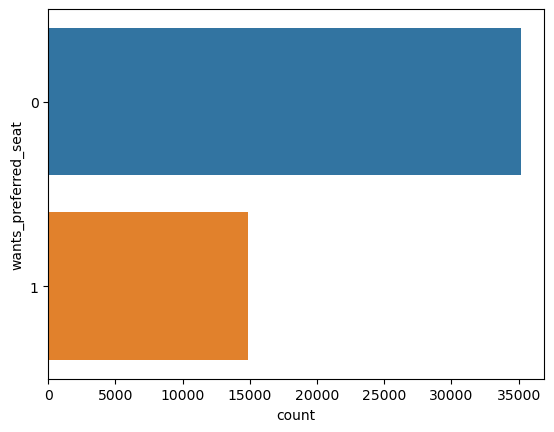

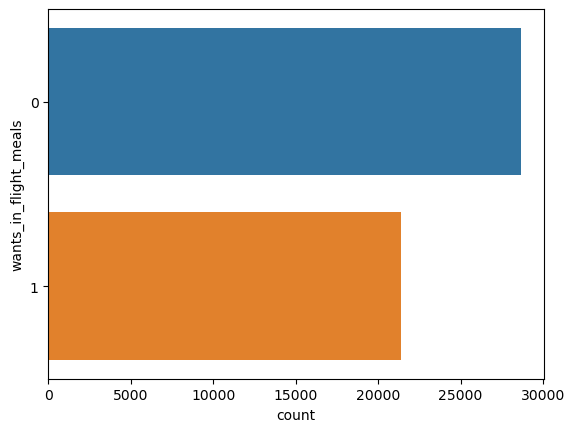

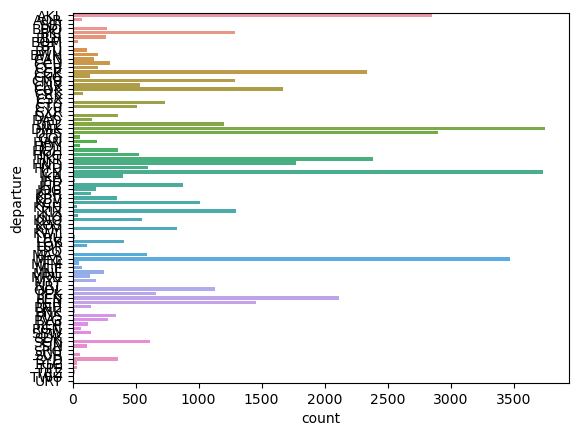

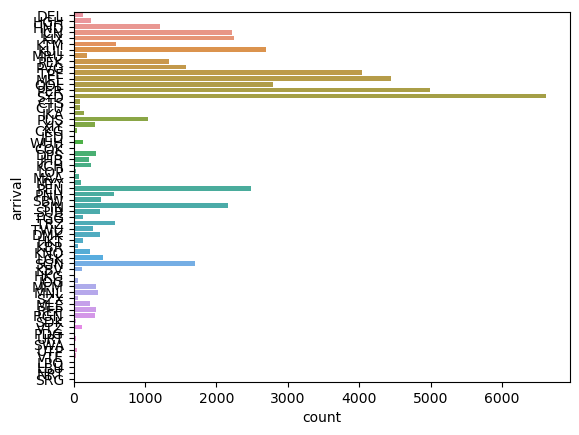

In [19]:

for col in data.select_dtypes(include='object'):
    if data[col].nunique() <= 100:
        sns.countplot(y=col, data=data)
        plt.show()

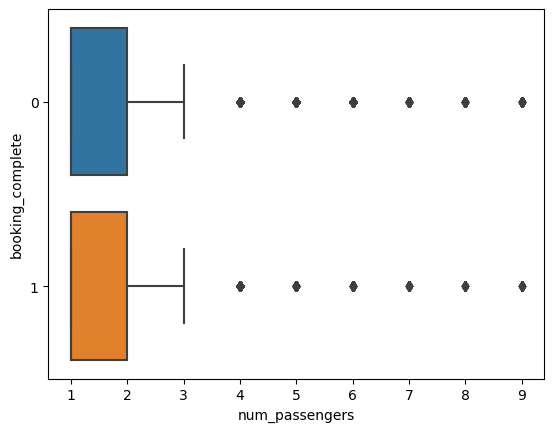

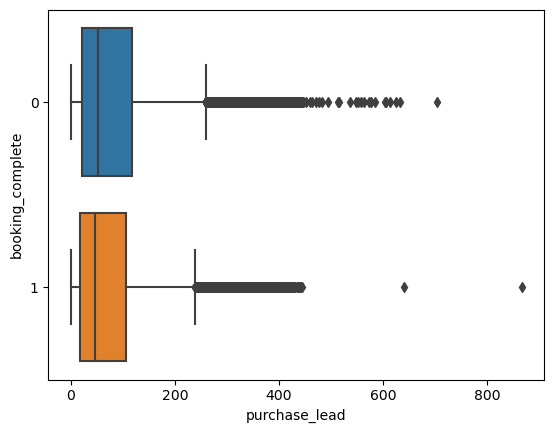

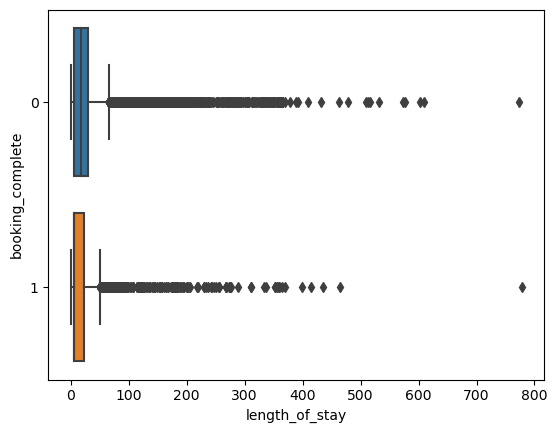

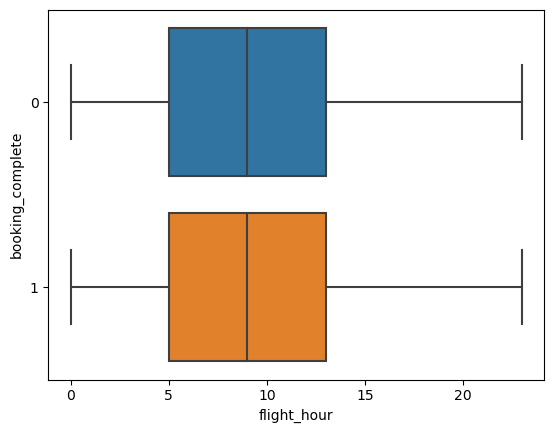

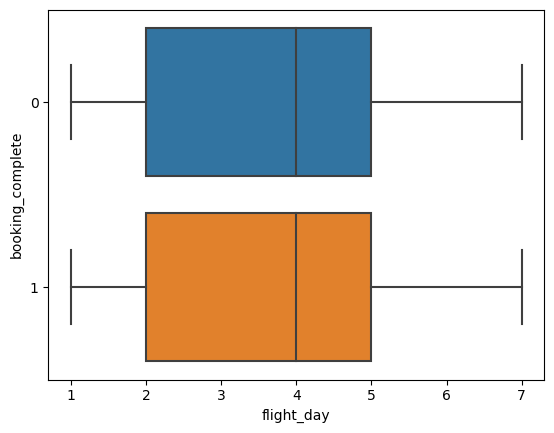

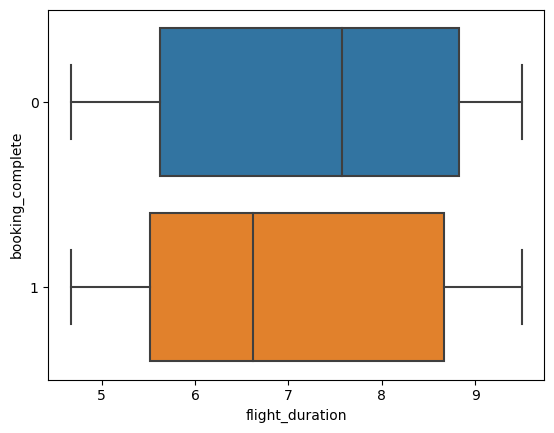

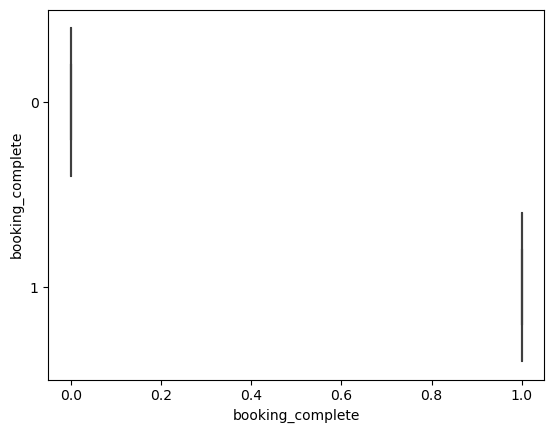

In [20]:
num_cols = data.select_dtypes(exclude='object').columns
for col in num_cols:
    sns.boxplot(y = data['booking_complete'].astype('category'), x = col, data=data)
    plt.show()

In [21]:
for col in data.select_dtypes(include='object'):
    if data[col].nunique() <=4:
        display(pd.crosstab(data['booking_complete'], data[col], normalize='index'))
        #display(pd.crosstab(data['target'], data[col]))

sales_channel,Internet,Mobile
booking_complete,,
0,0.882202,0.117798
1,0.918561,0.081439


trip_type,CircleTrip,OneWay,RoundTrip
booking_complete,,,
0,0.002610,0.008631,0.988759
1,0.000669,0.002675,0.996657


wants_extra_baggage,0,1
booking_complete,,
0,0.344669,0.655331
1,0.254747,0.745253


wants_preferred_seat,0,1
booking_complete,,
0,0.712643,0.287357
1,0.648435,0.351565


wants_in_flight_meals,0,1
booking_complete,,
0,0.578359,0.421641
1,0.541589,0.458411


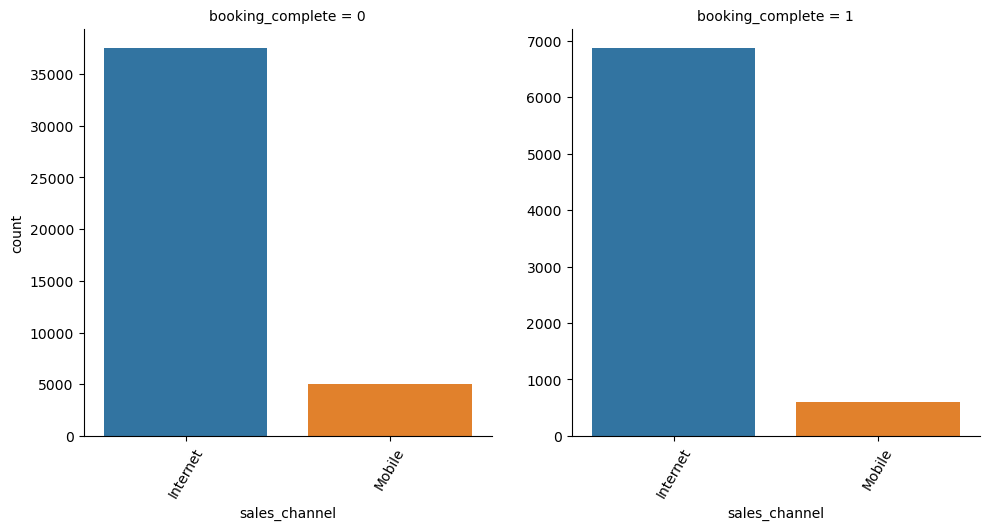

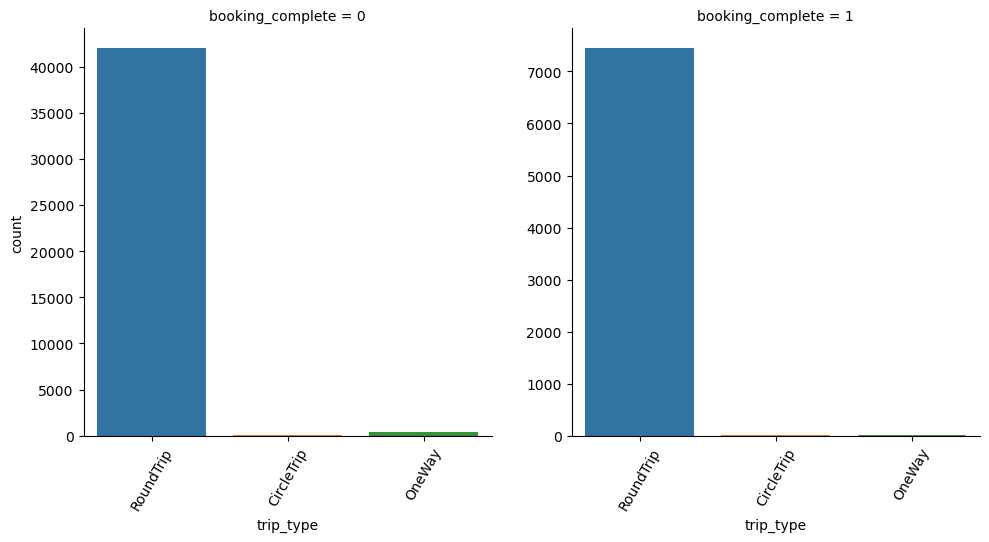

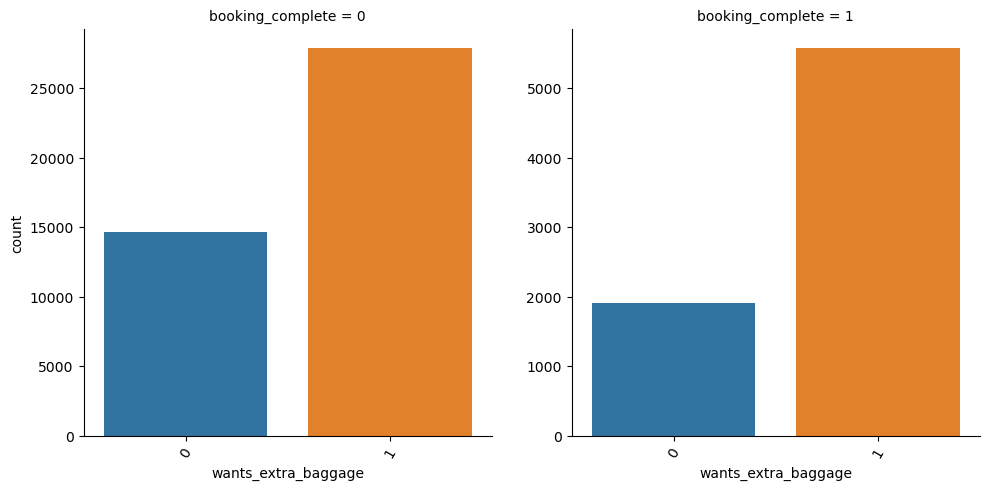

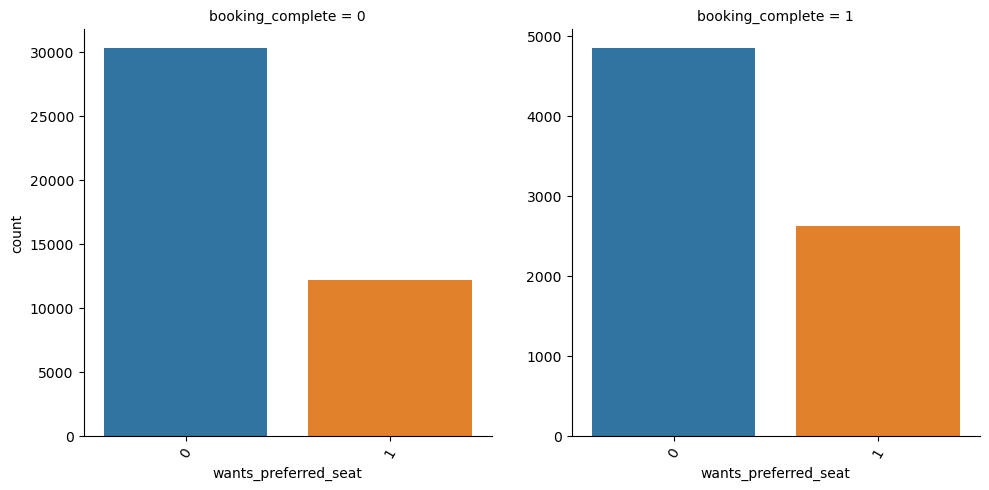

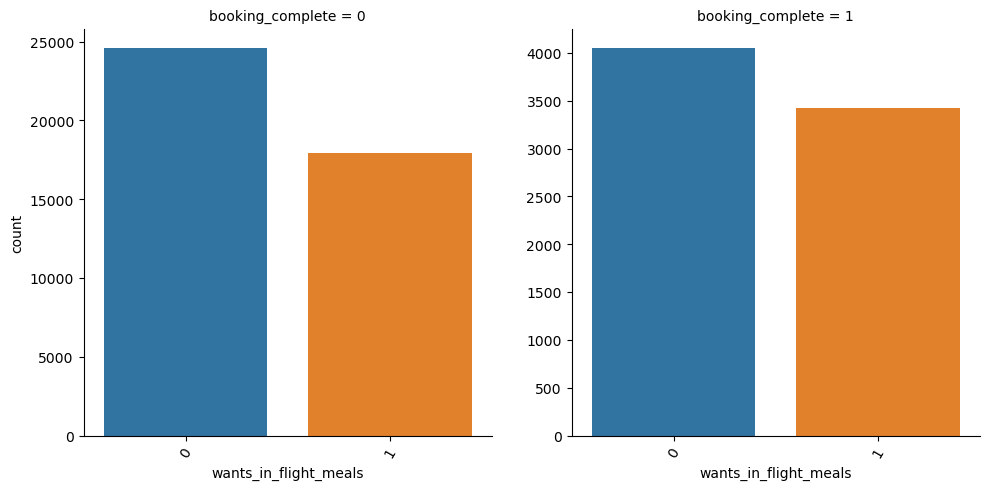

In [22]:

for col in data.select_dtypes(include='object'):
    if data[col].nunique() <= 4:
        g = sns.catplot(x = col, kind='count', col = 'booking_complete', data=data, sharey=False)
        g.set_xticklabels(rotation=60)

In [23]:
num_cols=data.select_dtypes(exclude='object').columns
for col in data.select_dtypes(include='object'):
    if data[col].nunique() <= 3:
        display(data.groupby(col)[num_cols].mean())

,num_passengers,purchase_lead,length_of_stay,flight_hour,flight_day,flight_duration,booking_complete
sales_channel,,,,,,,
Internet,1.592132,85.371682,23.772205,9.023253,3.784575,7.298133,0.154770
Mobile,1.584194,81.533998,17.296191,9.406728,4.050196,7.115043,0.108402


,num_passengers,purchase_lead,length_of_stay,flight_hour,flight_day,flight_duration,booking_complete
trip_type,,,,,,,
CircleTrip,1.568966,95.293103,25.224138,9.172414,3.982759,7.764828,0.043103
OneWay,1.565891,91.547804,18.036176,9.253230,3.759690,7.966770,0.051680
RoundTrip,1.591490,84.864557,23.078611,9.064630,3.814453,7.271030,0.150575


,num_passengers,purchase_lead,length_of_stay,flight_hour,flight_day,flight_duration,booking_complete
wants_extra_baggage,,,,,,,
0,1.416702,87.794638,14.533241,9.154278,3.821508,7.156208,0.115029
1,1.677682,83.526930,27.259876,9.022788,3.810909,7.337662,0.166662


,num_passengers,purchase_lead,length_of_stay,flight_hour,flight_day,flight_duration,booking_complete
wants_preferred_seat,,,,,,,
0,1.572315,85.204939,22.333978,9.023526,3.807436,7.179024,0.137944
1,1.636045,84.314386,24.726832,9.167699,3.830954,7.510842,0.177061


,num_passengers,purchase_lead,length_of_stay,flight_hour,flight_day,flight_duration,booking_complete
wants_in_flight_meals,,,,,,,
0,1.571030,86.709737,20.152707,9.005516,3.798450,7.078109,0.141396
1,1.618345,82.567636,26.922976,9.147914,3.835838,7.545056,0.160509


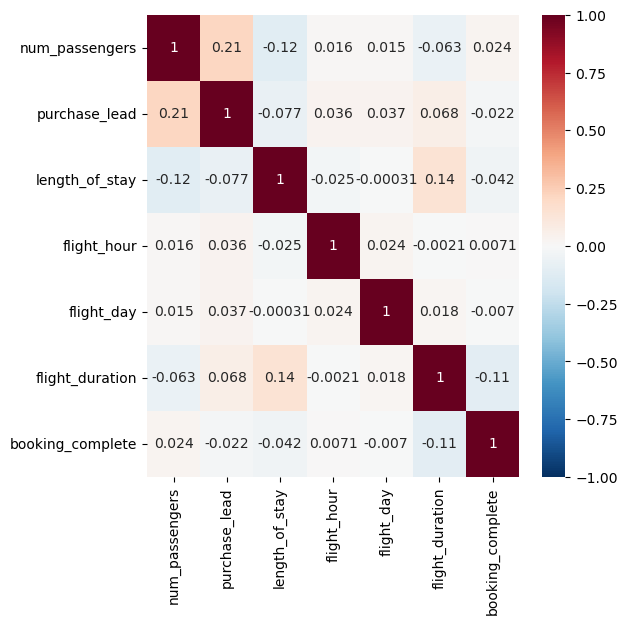

In [24]:
corr = data.corr()

plt.figure(figsize=(6,6))
sns.heatmap(corr, cmap='RdBu_r', annot=True, vmax=1, vmin=-1)
plt.show()

In [26]:
# ohe=OneHotEncoder()
# data=pd.DataFrame(ohe.fit_transform(datatrip_type']))

In [27]:


X=data.drop(columns='booking_complete')
y=data['booking_complete']

cat_cols=X.select_dtypes(include='object').columns
num_cols = X.select_dtypes(exclude="object").columns

enc = OrdinalEncoder()
X[cat_cols]=enc.fit_transform(X[cat_cols])

scale=StandardScaler()
X[num_cols]=scale.fit_transform(X[num_cols])


In [28]:
X

,num_passengers,sales_channel,trip_type,purchase_lead,length_of_stay,flight_hour,flight_day,booking_origin,wants_extra_baggage,wants_preferred_seat,wants_in_flight_meals,flight_duration,departure,arrival
0,0.400684,0.0,2.0,1.957530,-0.119353,-0.381764,1.096754,61.0,1.0,0.0,0.0,-1.174175,0.0,4.0
1,-0.579559,0.0,2.0,0.299164,-0.089844,-1.120780,1.096754,61.0,0.0,0.0,0.0,-1.174175,0.0,4.0
2,0.400684,0.0,2.0,1.747470,-0.030824,1.465775,-0.408687,36.0,1.0,1.0,0.0,-1.174175,0.0,4.0
3,-0.579559,0.0,2.0,0.122272,0.234761,-0.936026,1.096754,61.0,0.0,0.0,1.0,-1.174175,0.0,4.0
4,0.400684,0.0,2.0,-0.187290,-0.030824,1.096267,-0.408687,36.0,1.0,0.0,1.0,-1.174175,0.0,4.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
49995,0.400684,0.0,2.0,-0.640577,-0.502977,-0.012257,1.096754,4.0,1.0,0.0,1.0,-1.107368,66.0,40.0
49996,-0.579559,0.0,2.0,0.288108,-0.502977,-0.936026,1.598567,4.0,0.0,0.0,0.0,-1.107368,66.0,40.0
49997,-0.579559,0.0,2.0,-0.673744,-0.502977,2.389544,1.096754,4.0,0.0,0.0,1.0,-1.107368,66.0,40.0
49998,-0.579559,0.0,2.0,-0.773246,-0.502977,0.357251,-1.412314,4.0,1.0,0.0,1.0,-1.107368,66.0,40.0


In [29]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5, random_state=0)


In [30]:
# gnb = GaussianNB()
# tree = DecisionTreeClassifier()
xgbcl = xgb.XGBClassifier()
mlp = MLPClassifier()
rfcl= RandomForestClassifier()
#     cnb = ComplementNB()
model=[xgbcl, mlp,rfcl]
scores={}
for estimator in model:
    scores[str(estimator)]=cross_val_score(estimator,X_train,y_train,cv=5,scoring='roc_auc').mean()
scores

{'XGBClassifier(base_score=None, booster=None, callbacks=None,\n              colsample_bylevel=None, colsample_bynode=None,\n              colsample_bytree=None, early_stopping_rounds=None,\n              enable_categorical=False, eval_metric=None, feature_types=None,\n              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,\n              interaction_constraints=None, learning_rate=None, max_bin=None,\n              max_cat_threshold=None, max_cat_to_onehot=None,\n              max_delta_step=None, max_depth=None, max_leaves=None,\n              min_child_weight=None, missing=nan, monotone_constraints=None,\n              n_estimators=100, n_jobs=None, num_parallel_tree=None,\n              predictor=None, random_state=None, ...)': 0.7713285804328837,
 'MLPClassifier()': 0.7354909553435736,
 'RandomForestClassifier()': 0.7641844955013876}

In [31]:
# instances=pd.DataFrame(y).value_counts()
# pos=instances[0]/instances[1]
# pos

xgb_model=xgb.XGBClassifier(early_stopping_rounds=5, max_depth=10, n_estimators=1000, learning_rate=0.05, n_jobs=5)


xgb_model.fit(X_train,y_train,
              eval_set= [(X_test,y_test)],
              verbose=False)

y_pred =xgb_model.predict(X_test)
y_pred_train=xgb_model.predict(X_train)

print(f1_score(y_test,y_pred, average='weighted'))
print("Number of mislabeled points out of a total %d points : %d" % (X_test.shape[0], (y_test != y_pred).sum()))
print("Number of mislabeled points out of a total %d points : %d" % (X_train.shape[0], (y_train!= y_pred_train).sum()))

0.8001130954008516
Number of mislabeled points out of a total 25000 points : 3794
Number of mislabeled points out of a total 25000 points : 2788


In [32]:
feature=pd.DataFrame(X.columns)
feature['importance']=xgb_model.feature_importances_

<BarContainer object of 14 artists>

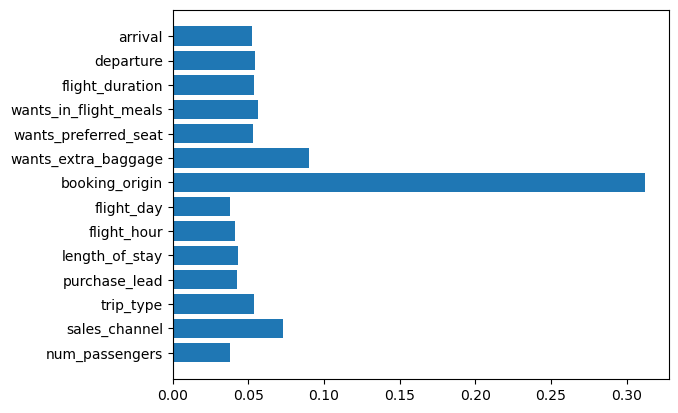

In [33]:
plt.barh(feature.iloc[:,0],feature.iloc[:,1])
